In [1]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path = Path("ppo_calib_7bf012e8.jsonl")

rows = []
bad = 0
with path.open("r", encoding="utf-8") as f:
    for i, line in enumerate(f, 1):
        line = line.strip()
        if not line:
            continue
        try:
            rows.append(json.loads(line))
        except Exception:
            bad += 1

df = pd.json_normalize(rows)
print("rows:", len(df), "bad_lines:", bad)
print("columns:", len(df.columns))
df.head(3)


rows: 2722 bad_lines: 0
columns: 53


,event,run_id,ep,seed,K_eff,theta_true_eval_only.battery_max,theta_true_eval_only.step_cost,theta_est.grid_size,theta_est.use_stay,theta_est.battery_max,...,acc_eval.acc/bat_mse,acc_eval.acc/rew_mae,acc_eval.acc/theta_mean_abs,acc_eval.abs_err/battery_max,acc_eval.abs_err/step_cost,base_loss_total,total_obj,smooth.battery_smooth,smooth.step_cost_smooth,smooth.pslip_smooth
0,reset,7bf012e8,1,0.0,200,30.0,0.1,10,False,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,oracle_update_skipped,7bf012e8,1,NaN,200,30.0,0.1,10,False,80,...,0.000434,0.0,25.0,50.0,0.0,NaN,NaN,NaN,NaN,NaN
2,oracle_update_skipped,7bf012e8,1,NaN,200,30.0,0.1,10,False,80,...,0.021918,0.0,25.0,50.0,0.0,NaN,NaN,NaN,NaN,NaN


In [4]:
import numpy as np
import pandas as pd

def last_update_per_episode(
    d: pd.DataFrame,
    *,
    event_col: str = "event",
    event_prefix: str = "oracle_update",
    key_cols=("log_mode", "ep"),
    time_col_candidates=("_x", "t_global", "update_idx"),
) -> pd.DataFrame:
    """
    Take only oracle_update* rows, group by (log_mode, ep), return the last row per group.
    Robust to missing _x: falls back to t_global or update_idx.
    """
    if not isinstance(d, pd.DataFrame):
        raise TypeError("d must be a pandas DataFrame")

    df = d.copy()

    # If event exists, keep only oracle_update*
    if event_col in df.columns:
        df = df[df[event_col].astype(str).str.startswith(event_prefix)].copy()

    # Ensure key cols exist; if log_mode missing, create a default
    for c in key_cols:
        if c not in df.columns:
            if c == "log_mode":
                df[c] = "train"
            else:
                raise ValueError(f"Missing column: {c}")

    # Choose sort column
    sort_col = None
    for c in time_col_candidates:
        if c in df.columns:
            sort_col = c
            break
    if sort_col is None:
        # Create a stable order if nothing exists
        df["_row"] = np.arange(len(df), dtype=int)
        sort_col = "_row"

    # Coerce sort col numeric when possible
    df[sort_col] = pd.to_numeric(df[sort_col], errors="coerce")
    df = df.dropna(subset=[sort_col]).copy()
    df = df.sort_values(sort_col)

    last = df.groupby(list(key_cols), as_index=False).tail(1)
    return last

def pick_metric_col(df: pd.DataFrame, candidates: list[str]) -> str:
    """
    Pick first existing column from candidates.
    """
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of the candidate columns exist. Tried: {candidates}. "
                   f"Available: {list(df.columns)[:60]}")

# usage:
last_ep = last_update_per_episode(df)

theta_col = pick_metric_col(
    last_ep,
    [
        "acc_eval.acc/theta_mean_abs",      # preferred: real GT eval (for Pareto)
        "acc_no_gt.acc/theta_mean_abs",     # fallback: proxy
        "acc.acc/theta_mean_abs",           # older logs
    ],
)

cols_to_show = ["log_mode", "ep", theta_col]
if "k_used_total" in last_ep.columns:
    cols_to_show.append("k_used_total")

last_ep[cols_to_show].head(5)


,log_mode,ep,acc_eval.acc/theta_mean_abs,k_used_total
4,train,1,25.0,4.0
9,train,2,25.0,8.0
14,train,3,25.0,12.0
19,train,4,25.0,16.0
24,train,5,25.0,20.0


In [8]:

%matplotlib inline
plt.rcParams["figure.dpi"] = 140
# Helpers
def _pick_xcol(df: pd.DataFrame) -> str:
    for c in ["t_global", "_x"]:
        if c in df.columns:
            return c
    raise KeyError("Need time column: expected 't_global' or '_x' in dataframe.")

def _maybe_num(df: pd.DataFrame, col: str) -> None:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

def _style_ax(ax):
    ax.grid(True, which="both", ls="--", alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

def _rolling(series: pd.Series, win: int, kind: str = "mean") -> pd.Series:
    if win is None or win <= 1:
        return series
    r = series.rolling(win, min_periods=max(3, win // 10))
    return r.mean() if kind == "mean" else r.median()

def prepare_df_for_plots(df: pd.DataFrame, only_updates: bool = False) -> pd.DataFrame:
    """
    - Sort by x-axis col
    - Optionally keep only oracle_update rows (good for theta trajectories)
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df must be a pandas DataFrame")

    d = df.copy()
    xcol = _pick_xcol(d)
    _maybe_num(d, xcol)

    # filter updates if requested
    if only_updates and "event" in d.columns:
        d = d[d["event"].astype(str).str.startswith("oracle_update")].copy()

    d = d.dropna(subset=[xcol]).sort_values(xcol)
    return d

def last_update_per_episode(d: pd.DataFrame,
                           key_cols=("log_mode", "ep"),
                           x_cols=("t_global", "_x"),
                           event_col="event",
                           event_prefixes=("oracle_update", "oracle_update_skipped"),
                           keep_events_only: bool = True) -> pd.DataFrame:

    if not isinstance(d, pd.DataFrame):
        raise TypeError("d must be a pandas DataFrame")

    dd = d.copy()

    # choose x col
    xcol = None
    for c in x_cols:
        if c in dd.columns:
            xcol = c
            break
    if xcol is None:
        raise KeyError(f"No x column found. Expected one of: {list(x_cols)}")

    # ensure keys exist; if log_mode missing, create a default
    for c in key_cols:
        if c not in dd.columns:
            if c == "log_mode":
                dd[c] = "train"
            else:
                raise ValueError(f"Missing column: {c}")
    if keep_events_only and event_col in dd.columns:
        ev = dd[event_col].astype(str)
        m = np.zeros(len(dd), dtype=bool)
        for p in event_prefixes:
            m |= ev.str.startswith(p)
        dd = dd[m].copy()

    # numeric + sort
    dd[xcol] = pd.to_numeric(dd[xcol], errors="coerce")
    dd = dd.dropna(subset=[xcol]).sort_values(xcol)

    last = dd.groupby(list(key_cols), as_index=False).tail(1)
    return last

def pick_theta_error_col(df: pd.DataFrame) -> str:

    for c in [
        "acc_eval.acc/theta_mean_abs",
        "acc_no_gt.acc/theta_mean_abs",
        "acc.acc/theta_mean_abs",
    ]:
        if c in df.columns:
            return c
    raise KeyError("No theta_mean_abs column found (acc_eval / acc_no_gt / acc.*).")

last_ep = last_update_per_episode(df)

theta_err_col = pick_theta_error_col(last_ep)
cols_preview = [c for c in ["log_mode", "ep", theta_err_col, "k_used_total"] if c in last_ep.columns]
display(last_ep[cols_preview].head(5))


,log_mode,ep,acc_eval.acc/theta_mean_abs,k_used_total
4,train,1,25.0,4.0
9,train,2,25.0,8.0
14,train,3,25.0,12.0
19,train,4,25.0,16.0
24,train,5,25.0,20.0


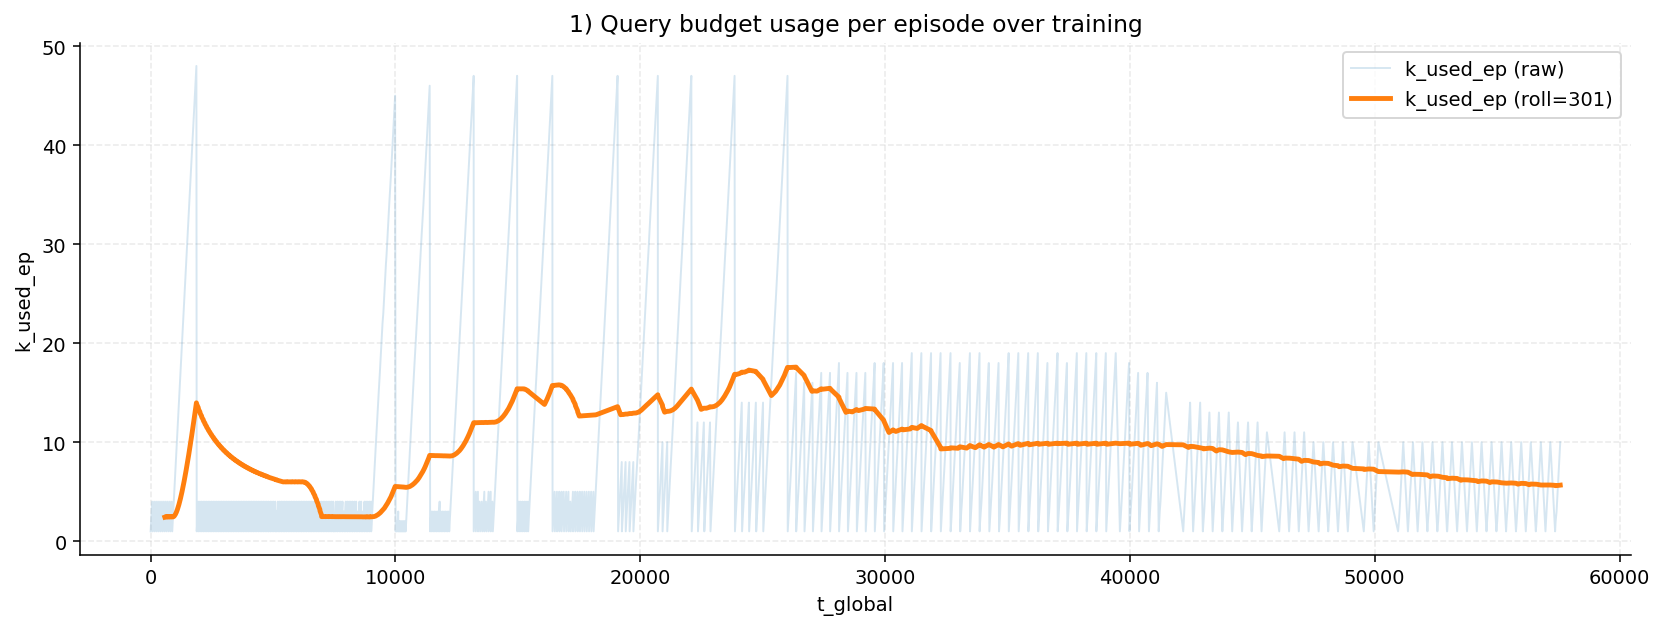

In [16]:
def plot_query_usage(df: pd.DataFrame, roll=301, mode="train"):
    d = prepare_df_for_plots(df)
    xcol = _pick_xcol(d)
    if "log_mode" in d.columns and mode is not None:
        d = d[d["log_mode"] == mode].copy()

    if "k_used_ep" not in d.columns:
        raise KeyError("Missing column 'k_used_ep' for Plot 1.")

    _maybe_num(d, "k_used_ep")

    plt.figure(figsize=(12, 4.6))
    plt.plot(d[xcol], d["k_used_ep"], alpha=0.18, linewidth=1, label="k_used_ep (raw)")
    plt.plot(d[xcol], _rolling(d["k_used_ep"], roll), linewidth=2.5, label=f"k_used_ep (roll={roll})")

    plt.title("1) Query budget usage per episode over training")
    plt.xlabel(xcol)
    plt.ylabel("k_used_ep")
    _style_ax(plt.gca())
    plt.legend(loc="upper right", frameon=True)
    plt.tight_layout()
    plt.show()
plot_query_usage(df, roll=301, mode="train")

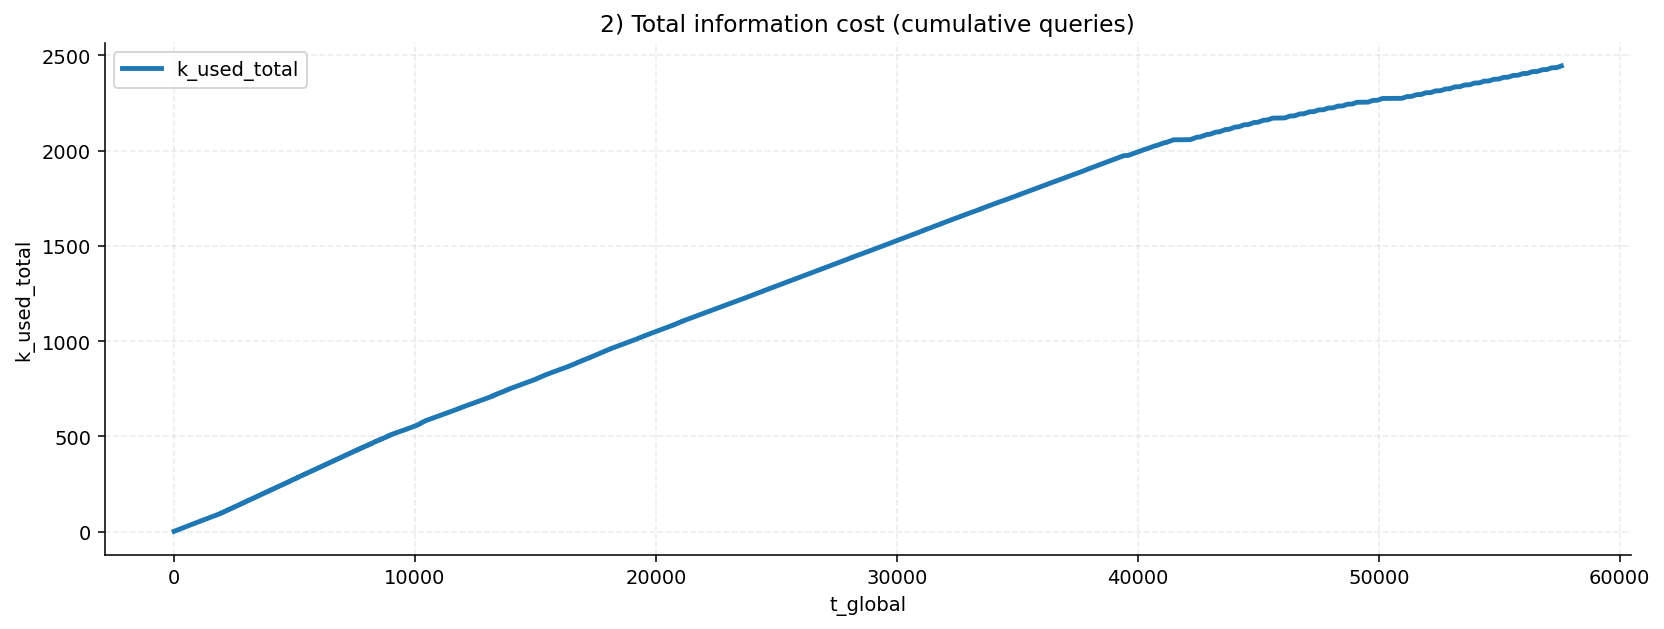

In [17]:
def plot_total_queries(df: pd.DataFrame, roll=301, mode="train"):
    d = prepare_df_for_plots(df)
    xcol = _pick_xcol(d)

    if "log_mode" in d.columns and mode is not None:
        d = d[d["log_mode"] == mode].copy()

    if "k_used_total" not in d.columns:
        raise KeyError("Missing column 'k_used_total' for Plot 2.")

    _maybe_num(d, "k_used_total")

    plt.figure(figsize=(12, 4.6))
    plt.plot(d[xcol], d["k_used_total"], linewidth=2.5, label="k_used_total")

    plt.title("2) Total information cost (cumulative queries)")
    plt.xlabel(xcol)
    plt.ylabel("k_used_total")
    _style_ax(plt.gca())
    plt.legend(loc="upper left", frameon=True)
    plt.tight_layout()
    plt.show()
plot_total_queries(df, roll=301, mode="train")


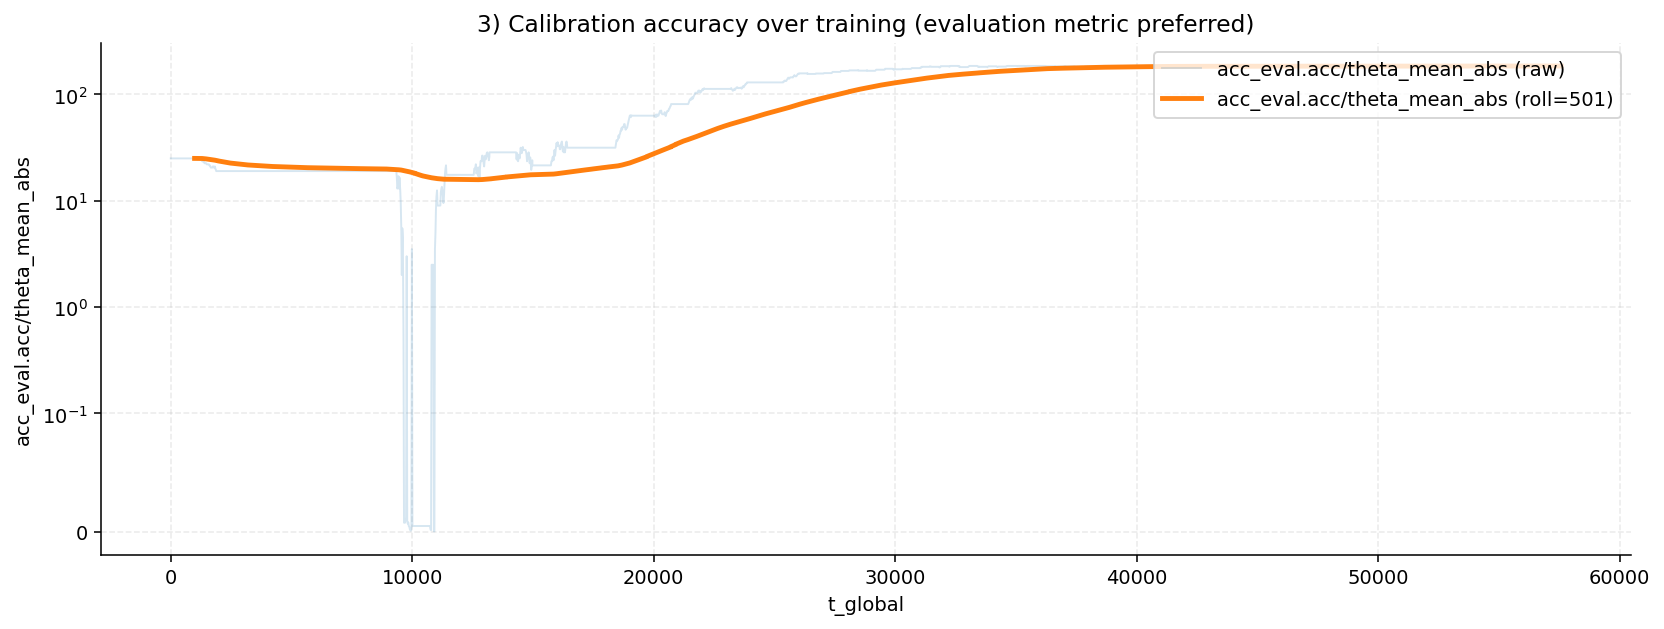

In [18]:
def plot_calibration_accuracy(df: pd.DataFrame, roll=501, mode="train"):
    d = prepare_df_for_plots(df)
    xcol = _pick_xcol(d)

    if "log_mode" in d.columns and mode is not None:
        d = d[d["log_mode"] == mode].copy()

    ycol = pick_theta_error_col(d)
    _maybe_num(d, ycol)

    plt.figure(figsize=(12, 4.6))
    plt.plot(d[xcol], d[ycol], alpha=0.18, linewidth=1, label=f"{ycol} (raw)")
    plt.plot(d[xcol], _rolling(d[ycol], roll), linewidth=2.5, label=f"{ycol} (roll={roll})")

    plt.title("3) Calibration accuracy over training (evaluation metric preferred)")
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.yscale("symlog", linthresh=0.1)
    _style_ax(plt.gca())
    plt.legend(loc="upper right", frameon=True)
    plt.tight_layout()
    plt.show()


plot_calibration_accuracy(df, roll=501, mode="train")

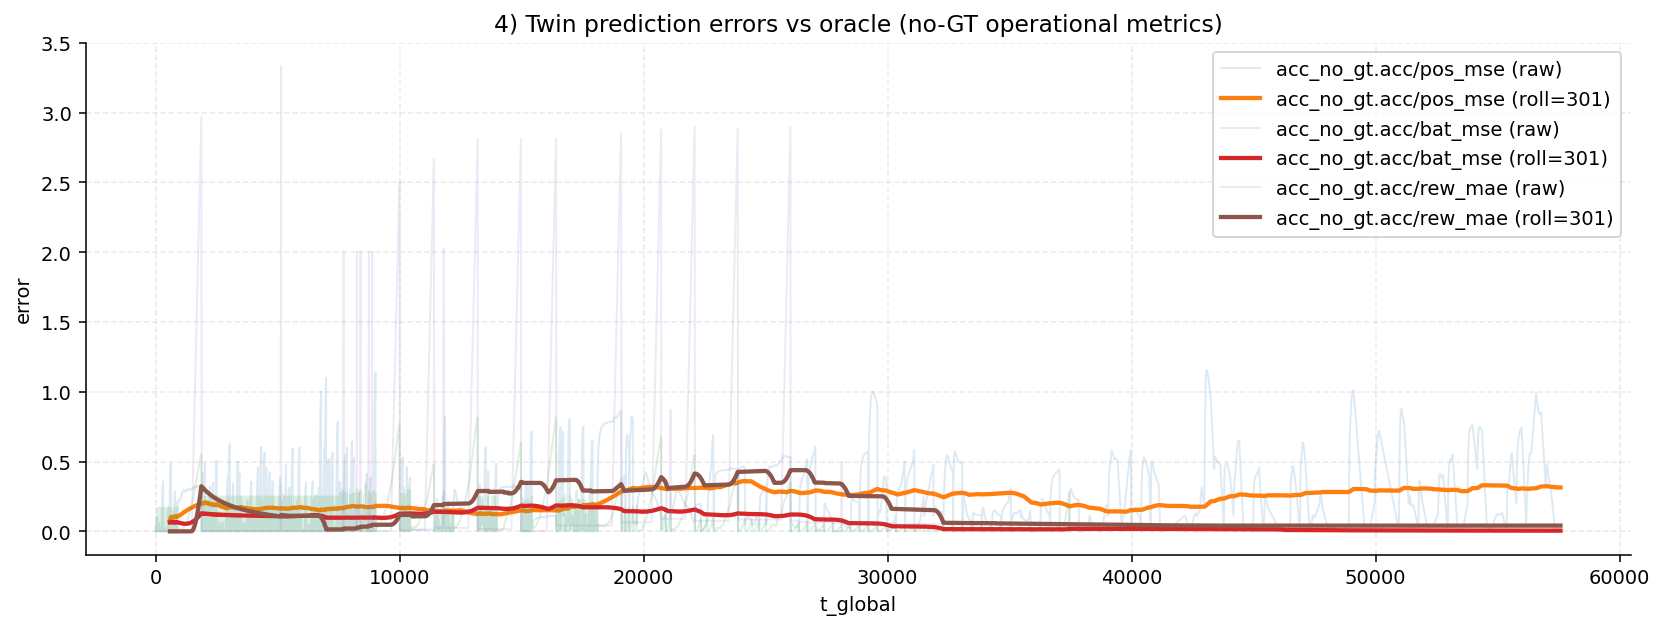

In [19]:
def plot_twin_prediction_errors(df: pd.DataFrame, roll=301, mode="train"):
    d = prepare_df_for_plots(df)
    xcol = _pick_xcol(d)

    if "log_mode" in d.columns and mode is not None:
        d = d[d["log_mode"] == mode].copy()

    cols = [
        "acc_no_gt.acc/pos_mse",
        "acc_no_gt.acc/bat_mse",
        "acc_no_gt.acc/rew_mae",
    ]
    available = [c for c in cols if c in d.columns]
    if len(available) == 0:
        raise KeyError(f"None of required no-GT columns found. Expected one of: {cols}")

    for c in available:
        _maybe_num(d, c)

    plt.figure(figsize=(12, 4.6))
    for c in available:
        plt.plot(d[xcol], d[c], alpha=0.15, linewidth=1, label=f"{c} (raw)")
        plt.plot(d[xcol], _rolling(d[c], roll), linewidth=2.2, label=f"{c} (roll={roll})")

    plt.title("4) Twin prediction errors vs oracle (no-GT operational metrics)")
    plt.xlabel(xcol)
    plt.ylabel("error")
    _style_ax(plt.gca())
    plt.legend(loc="upper right", frameon=True, ncol=1)
    plt.tight_layout()
    plt.show()
plot_twin_prediction_errors(df, roll=301, mode="train")


In [12]:
def plot_param_trajectory(df: pd.DataFrame, param: str, mode="train", roll=None):
    """
    param: "battery_max" or "step_cost" (works for any theta_est.<param>)
    Uses only update rows if event column exists (cleaner).
    """
    d = prepare_df_for_plots(df, only_updates=True)
    xcol = _pick_xcol(d)

    if "log_mode" in d.columns and mode is not None:
        d = d[d["log_mode"] == mode].copy()

    est_col = f"theta_est.{param}"
    true_col = f"theta_true_eval_only.{param}"

    if est_col not in d.columns:
        raise KeyError(f"Missing '{est_col}' for Plot 5.")

    _maybe_num(d, est_col)
    if true_col in d.columns:
        _maybe_num(d, true_col)

    plt.figure(figsize=(12, 4.6))

    y_est = d[est_col]
    if roll and roll > 1:
        plt.plot(d[xcol], y_est, alpha=0.15, linewidth=1, label=f"{est_col} (raw)")
        plt.plot(d[xcol], _rolling(y_est, roll), linewidth=2.6, label=f"{est_col} (roll={roll})")
    else:
        plt.plot(d[xcol], y_est, linewidth=2.6, label=est_col)

    if true_col in d.columns and d[true_col].notna().any():
        plt.plot(d[xcol], d[true_col], linestyle="--", linewidth=2.2, label=f"{true_col} (eval-only)")

    plt.title(f"5) Parameter trajectory: {param} (estimated vs true if available)")
    plt.xlabel(xcol)
    plt.ylabel(param)
    _style_ax(plt.gca())
    plt.legend(loc="best", frameon=True)
    plt.tight_layout()
    plt.show()


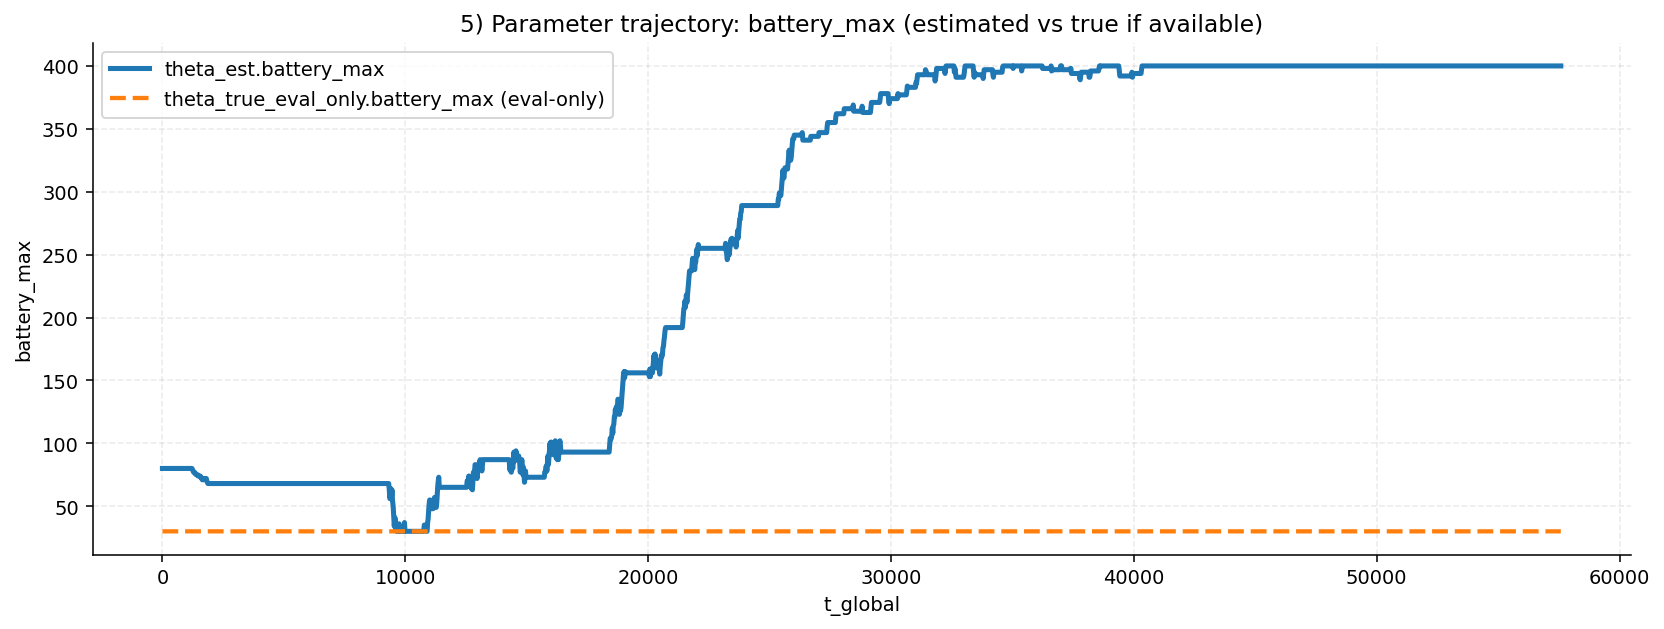

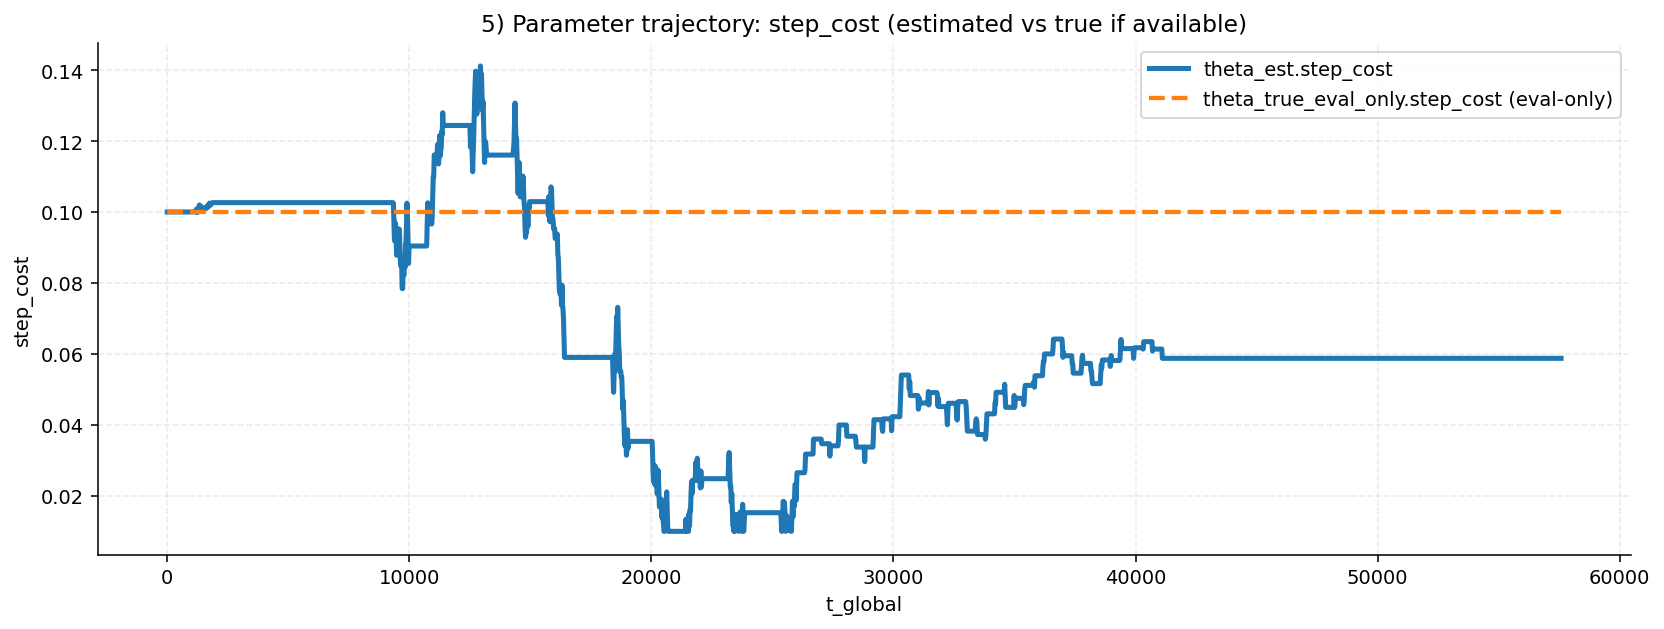

In [20]:

plot_param_trajectory(df, param="battery_max", mode="train", roll=None)
plot_param_trajectory(df, param="step_cost", mode="train", roll=None)


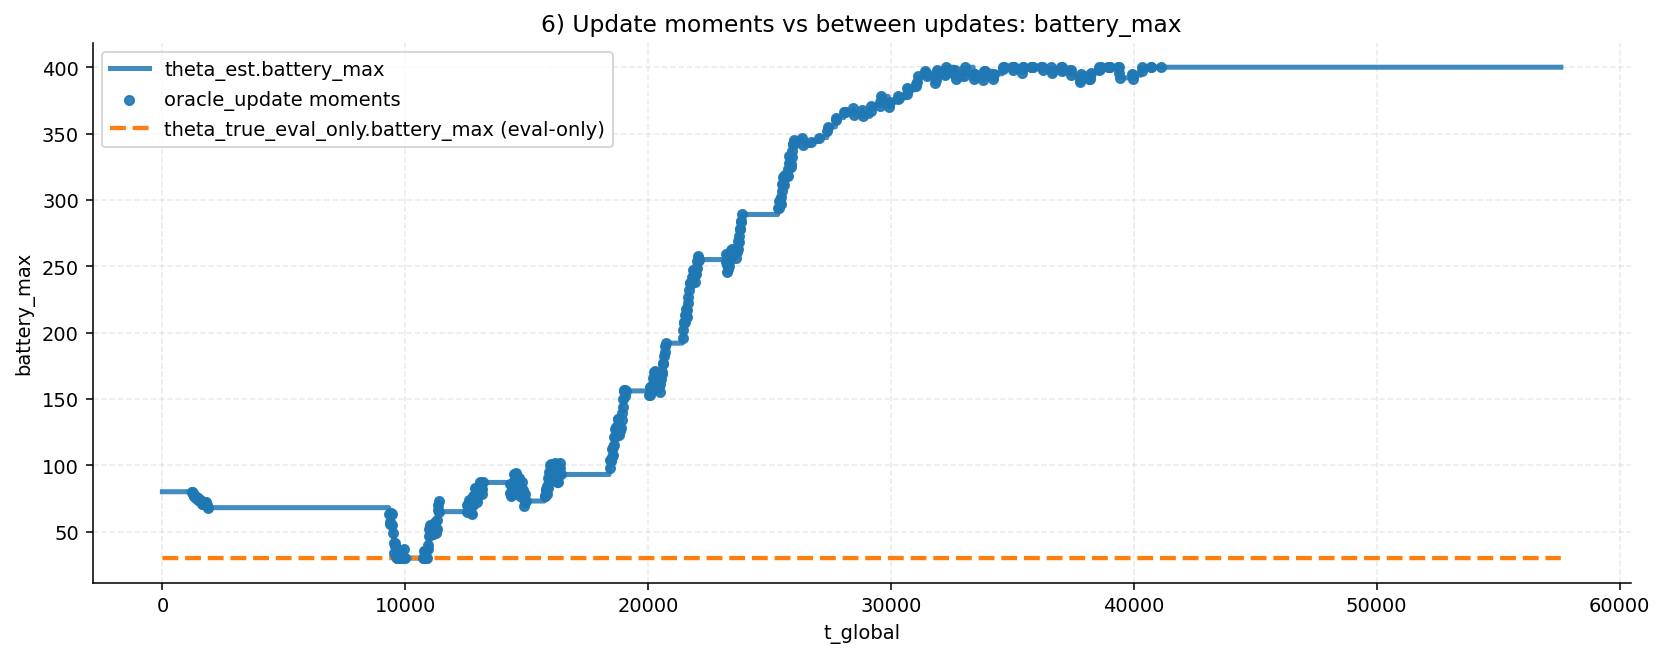

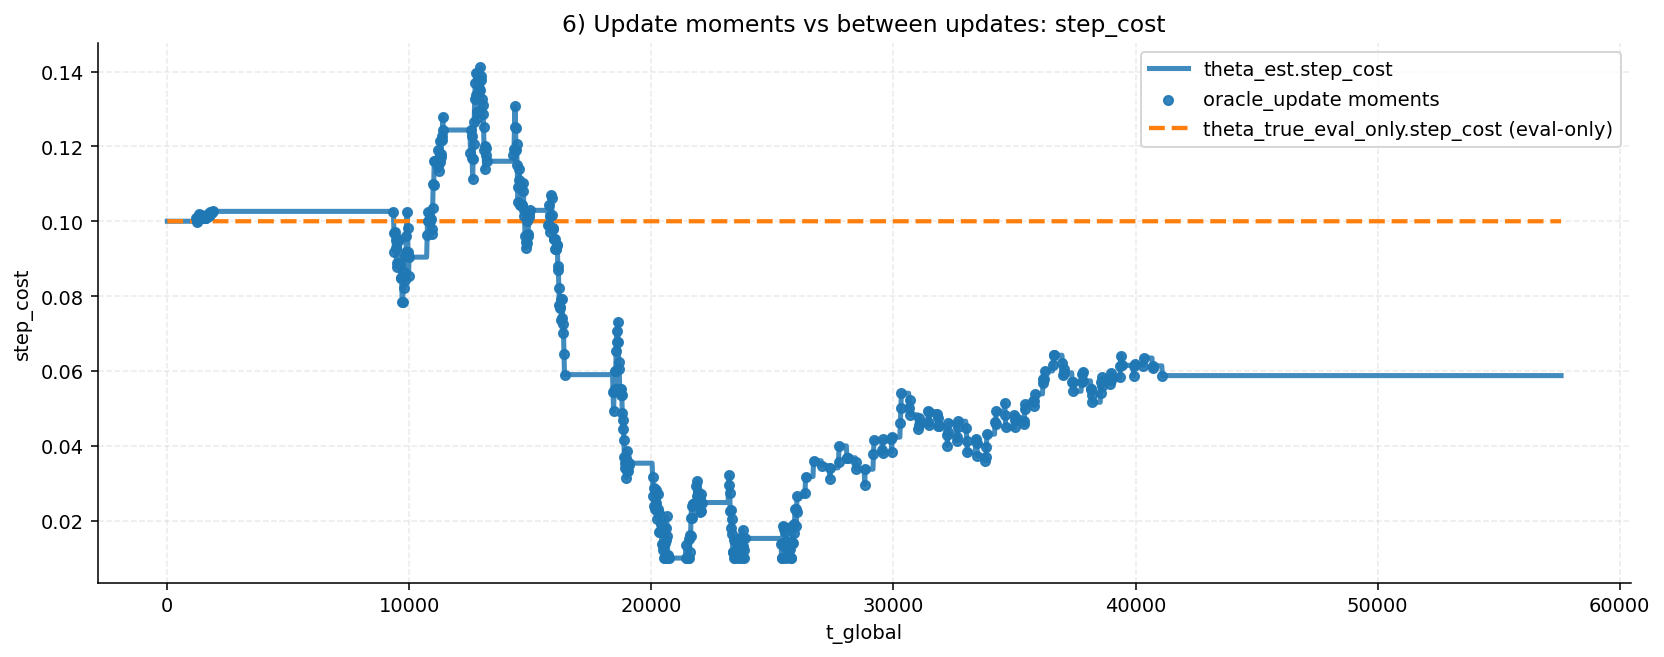

In [23]:

# Plot 6: Update moments vs between updates
def plot_updates_vs_between(df: pd.DataFrame, param: str,
                            mode="train",
                            show_true=True,
                            markersize=22,
                            alpha_line=0.85,
                            alpha_pts=0.9):
    """
    Shows theta_est.<param> as a continuous trajectory and highlights oracle_update events.
    Between updates, theta is typically flat; update moments become visible as jumps + markers.

    If theta_true_eval_only.<param> exists, overlays it as dashed line (eval-only).
    """
    d_all = prepare_df_for_plots(df, mode=mode, only_updates=False)
    xcol = _pick_xcol(d_all)

    est_col = f"theta_est.{param}"
    true_col = f"theta_true_eval_only.{param}"
    if est_col not in d_all.columns:
        raise KeyError(f"Missing '{est_col}' in df.")

    _maybe_num(d_all, est_col)
    if true_col in d_all.columns:
        _maybe_num(d_all, true_col)

    # update points
    if "event" in d_all.columns:
        is_upd = d_all["event"].astype(str).eq("oracle_update")
        d_upd = d_all[is_upd].copy()
    else:
        d_upd = d_all.iloc[0:0].copy()  # empty

    plt.figure(figsize=(12, 4.8))
    plt.plot(d_all[xcol], d_all[est_col], linewidth=2.6, alpha=alpha_line, label=est_col)

    if len(d_upd) > 0:
        plt.scatter(d_upd[xcol], d_upd[est_col], s=markersize, alpha=alpha_pts,
                    label="oracle_update moments", zorder=5)

    if show_true and (true_col in d_all.columns) and d_all[true_col].notna().any():
        plt.plot(d_all[xcol], d_all[true_col], linestyle="--", linewidth=2.2,
                 label=f"{true_col} (eval-only)")

    plt.title(f"6) Update moments vs between updates: {param}")
    plt.xlabel(xcol)
    plt.ylabel(param)
    _style_ax(plt.gca())
    plt.legend(loc="best", frameon=True)
    plt.tight_layout()
    plt.show()

plot_updates_vs_between(df, param="battery_max", mode="train", show_true=True)
plot_updates_vs_between(df, param="step_cost", mode="train", show_true=True)



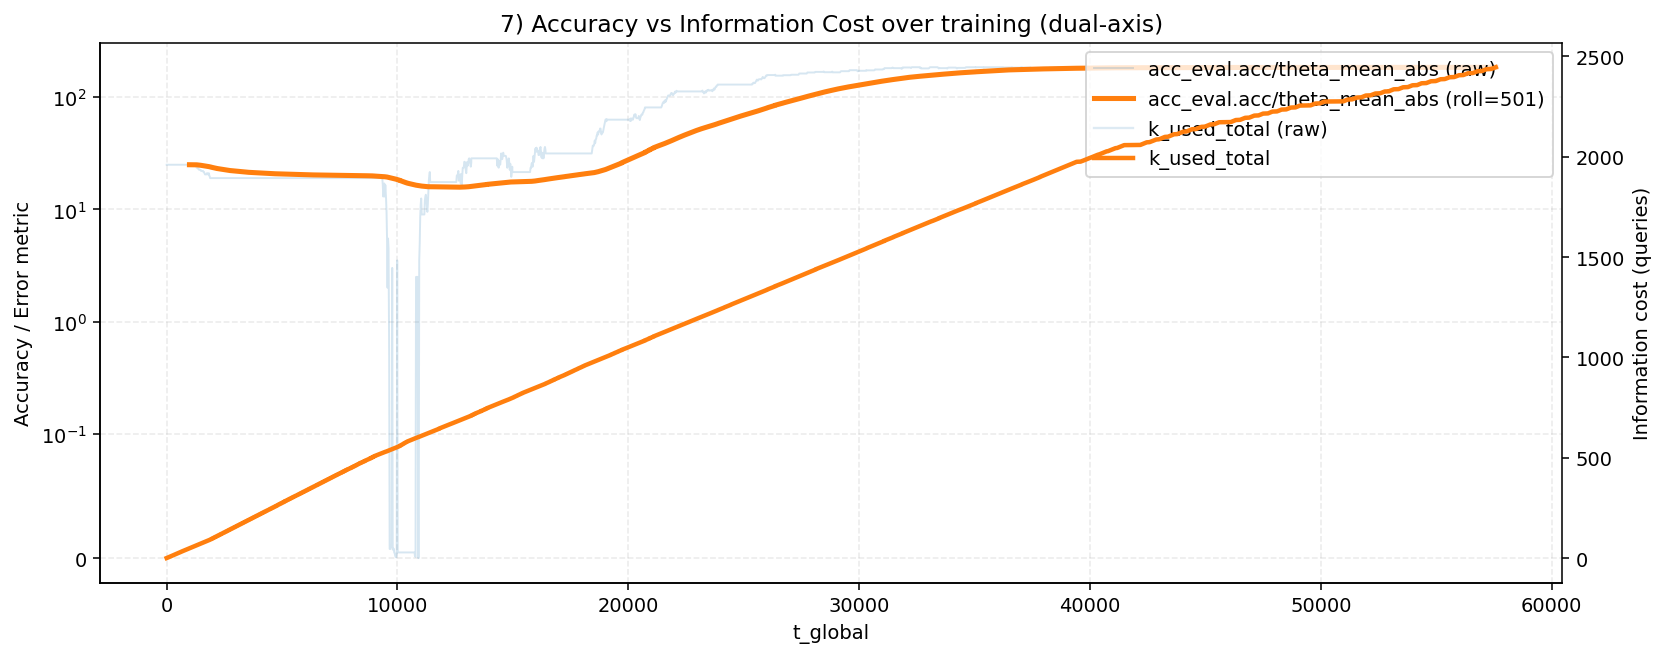

In [24]:
def plot_dual_axis_accuracy_queries(df: pd.DataFrame,
                                   mode="train",
                                   acc_col=None,
                                   queries_col="k_used_total",
                                   roll_acc=501,
                                   roll_q=None,
                                   use_symlog=True):
    """
    Left axis: accuracy (eval preferred)
    Right axis: queries (cumulative or per-episode)
    """
    d = prepare_df_for_plots(df, mode=mode, only_updates=False)
    xcol = _pick_xcol(d)

    if acc_col is None:
        acc_col = pick_theta_error_col(d)

    for c in [acc_col, queries_col]:
        if c not in d.columns:
            raise KeyError(f"Missing column '{c}'")
        _maybe_num(d, c)

    # drop NaNs
    dd = d[[xcol, acc_col, queries_col]].dropna().copy()
    if len(dd) == 0:
        print("Nothing to plot after dropna.")
        return

    x = dd[xcol]
    acc = dd[acc_col]
    q = dd[queries_col]

    acc_s = _rolling(acc, roll_acc) if roll_acc else acc
    q_s = _rolling(q, roll_q) if roll_q else q

    fig, ax1 = plt.subplots(figsize=(12, 4.8))

    # accuracy on left
    ax1.plot(x, acc, alpha=0.18, linewidth=1, label=f"{acc_col} (raw)")
    ax1.plot(x, acc_s, linewidth=2.6, label=f"{acc_col} (roll={roll_acc})")
    ax1.set_xlabel(xcol)
    ax1.set_ylabel("Accuracy / Error metric")
    if use_symlog:
        ax1.set_yscale("symlog", linthresh=0.1)

    _style_ax(ax1)

    # queries on right
    ax2 = ax1.twinx()
    ax2.plot(x, q, alpha=0.15, linewidth=1.2, label=f"{queries_col} (raw)")
    ax2.plot(x, q_s, linewidth=2.3, label=f"{queries_col}" + (f" (roll={roll_q})" if roll_q else ""))
    ax2.set_ylabel("Information cost (queries)")

    # combine legends
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper right", frameon=True)

    plt.title("7) Accuracy vs Information Cost over training (dual-axis)")
    plt.tight_layout()
    plt.show()

# 7) Dual-axis: accuracy + queries
plot_dual_axis_accuracy_queries(
    df,
    mode="train",
    acc_col=None,              # auto-pick eval preferred
    queries_col="k_used_total",
    roll_acc=501,
    roll_q=None,
    use_symlog=True,
)


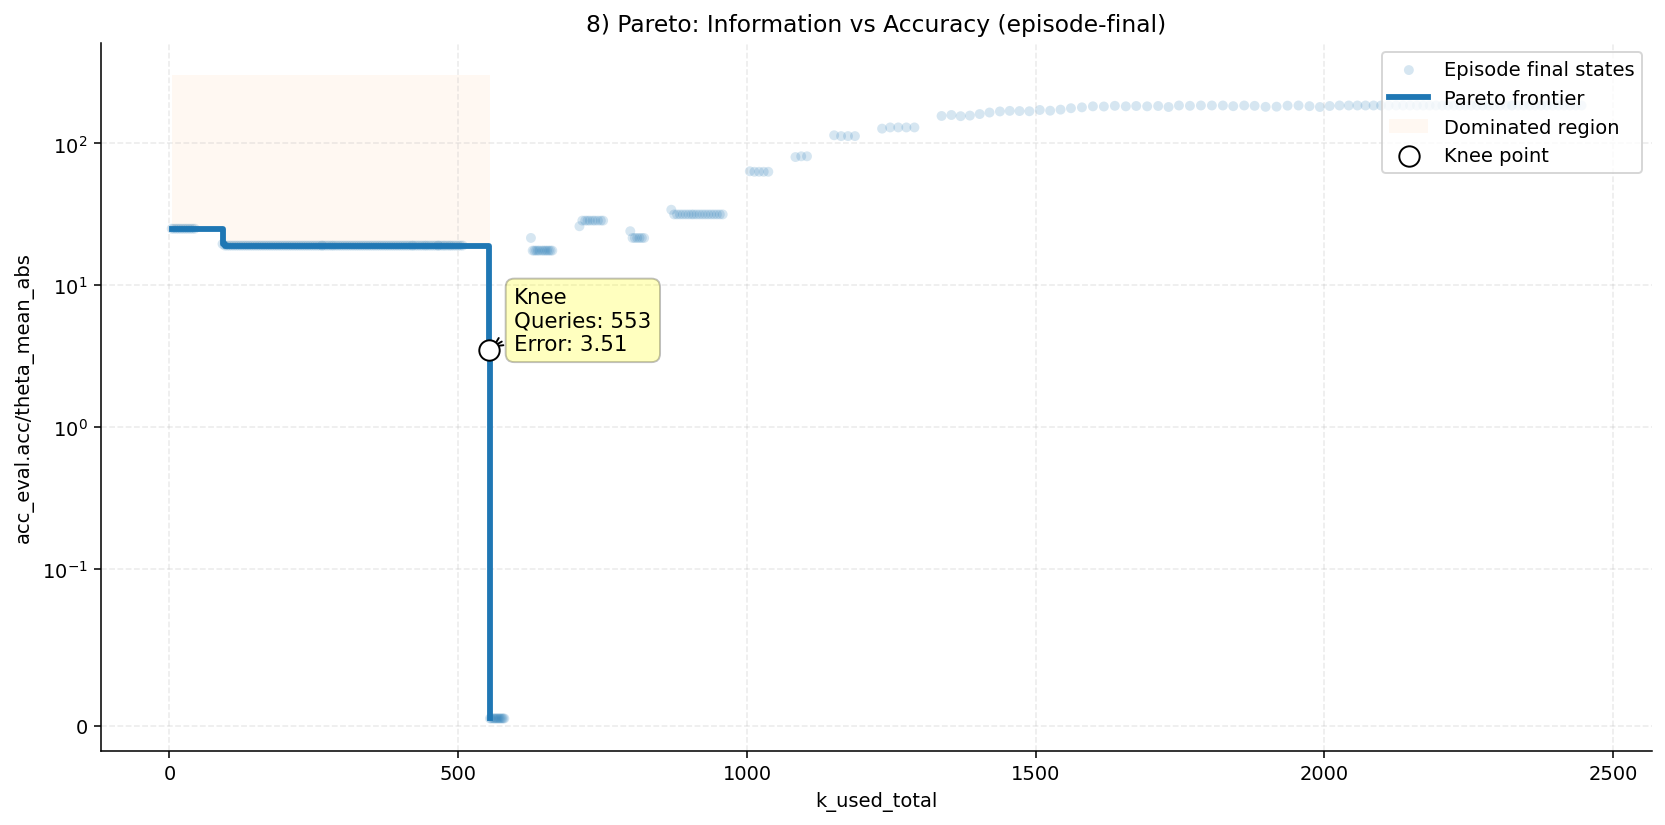

In [25]:
def pareto_frontier_points(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if len(x) == 0:
        return np.asarray([]), np.asarray([])

    order = np.lexsort((y, x))
    x_s, y_s = x[order], y[order]

    # compress equal x -> min y
    ux, idx_start = np.unique(x_s, return_index=True)
    y_min = np.empty_like(ux, dtype=float)
    for i in range(len(ux)):
        j0 = idx_start[i]
        j1 = idx_start[i + 1] if i + 1 < len(ux) else len(x_s)
        y_min[i] = np.min(y_s[j0:j1])

    px, py = [], []
    best_y = np.inf
    for xi, yi in zip(ux, y_min):
        if yi < best_y:
            px.append(xi)
            py.append(yi)
            best_y = yi

    return np.asarray(px), np.asarray(py)

def staircase_xy(px, py):
    px = np.asarray(px, dtype=float)
    py = np.asarray(py, dtype=float)
    if len(px) == 0:
        return px, py
    sx = [px[0]]
    sy = [py[0]]
    for i in range(1, len(px)):
        sx.append(px[i]); sy.append(py[i-1])
        sx.append(px[i]); sy.append(py[i])
    return np.asarray(sx), np.asarray(sy)

def knee_max_distance_to_chord(px, py, y_transform="log1p"):
    px = np.asarray(px, dtype=float)
    py = np.asarray(py, dtype=float)
    if len(px) < 3:
        return 0

    x = px.copy()
    if y_transform == "log1p":
        y = np.log1p(np.maximum(py, 0.0))
    elif y_transform == "none":
        y = py.copy()
    else:
        raise ValueError("y_transform must be 'none' or 'log1p'")

    x_n = (x - x.min()) / (x.max() - x.min() + 1e-12)
    y_n = (y - y.min()) / (y.max() - y.min() + 1e-12)

    x1, y1 = x_n[0], y_n[0]
    x2, y2 = x_n[-1], y_n[-1]
    denom = np.hypot(x2 - x1, y2 - y1) + 1e-12
    dist = np.abs((y2 - y1) * x_n - (x2 - x1) * y_n + x2 * y1 - y2 * x1) / denom

    return 1 + int(np.argmax(dist[1:-1]))  # avoid endpoints

def pareto_plot_episode_frontier(last_ep: pd.DataFrame, title: str,
                                 mode="train",
                                 x_col="k_used_total",
                                 y_col=None):
    """
    Uses last update per episode (recommended). y_col defaults to acc_eval.acc/theta_mean_abs if available.
    """
    if y_col is None:
        y_col = pick_theta_error_col(last_ep)

    df = last_ep.copy()
    if "log_mode" in df.columns and mode is not None:
        df = df[df["log_mode"] == mode].copy()

    for c in [x_col, y_col]:
        if c not in df.columns:
            raise KeyError(f"Missing '{c}'")
        _maybe_num(df, c)

    df = df[[x_col, y_col]].dropna()
    df = df[np.isfinite(df[x_col]) & np.isfinite(df[y_col])]
    if len(df) == 0:
        print("Nothing to plot.")
        return

    x = df[x_col].to_numpy(float)
    y = df[y_col].to_numpy(float)

    plt.figure(figsize=(12, 6))
    plt.scatter(x, y, alpha=0.18, s=26, label="Episode final states", edgecolors="none")

    px, py = pareto_frontier_points(x, y)
    if len(px) >= 2:
        sx, sy = staircase_xy(px, py)
        k_idx = knee_max_distance_to_chord(px, py, y_transform="log1p")
        kx, ky = px[k_idx], py[k_idx]

        plt.yscale("symlog", linthresh=0.1)
        plt.plot(sx, sy, linewidth=3, label="Pareto frontier")

        y_top = plt.gca().get_ylim()[1]
        plt.fill_between(sx, sy, y_top, alpha=0.05, label="Dominated region")

        plt.scatter([kx], [ky], color="white", edgecolor="black", s=110, zorder=5, label="Knee point")
        plt.annotate(
            f"Knee\nQueries: {kx:.0f}\nError: {ky:.2f}",
            xy=(kx, ky),
            xytext=(kx + 0.08*(px.max()-px.min()+1e-9), ky),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.15"),
            fontsize=11,
            bbox=dict(boxstyle="round,pad=0.4", fc="yellow", alpha=0.25),
        )
    else:
        plt.yscale("symlog", linthresh=0.1)
        print("WARNING: frontier has <2 points; plotting only scatter.")

    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    _style_ax(plt.gca())
    plt.legend(loc="upper right", frameon=True)
    plt.tight_layout()
    plt.show()

# Pareto
pareto_plot_episode_frontier(last_ep, "8) Pareto: Information vs Accuracy (episode-final)", mode="train")


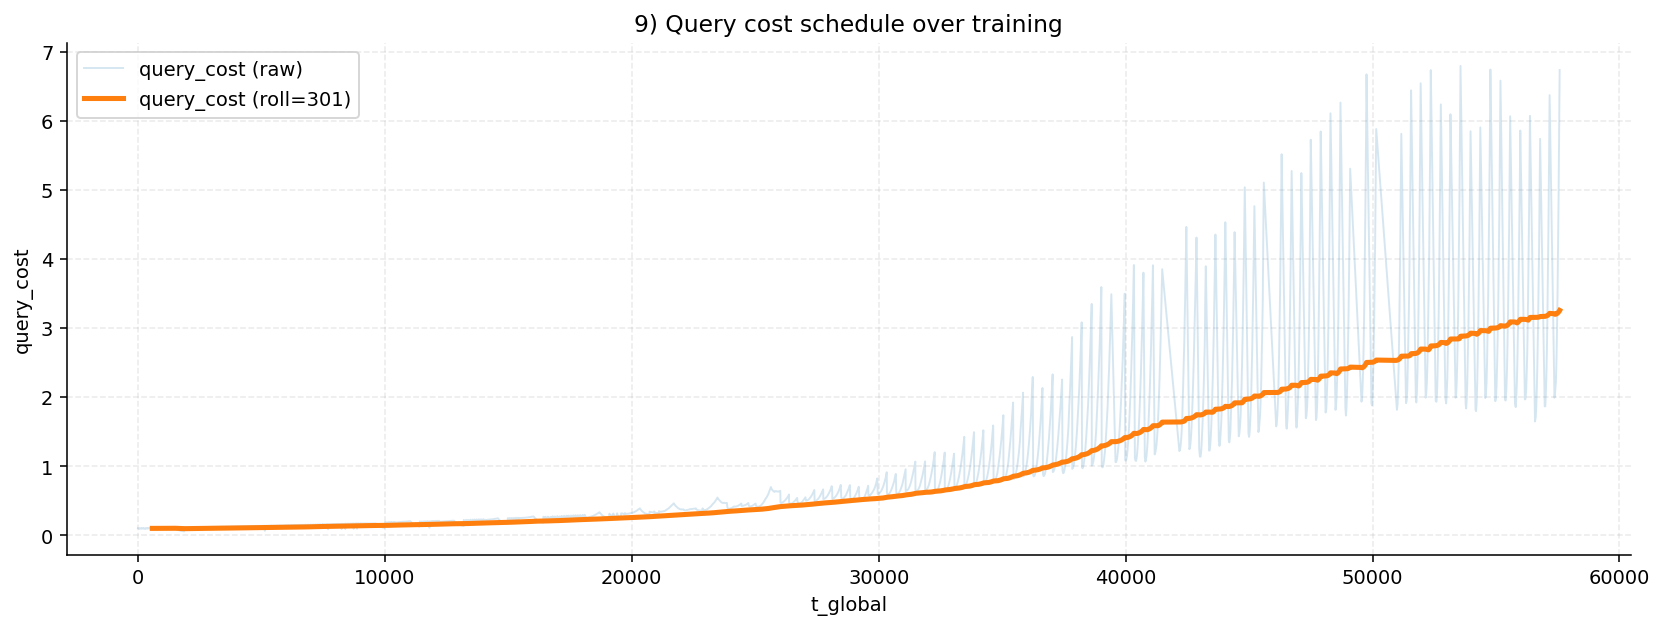

In [26]:
def plot_query_cost(df: pd.DataFrame, roll=301, mode="train", col="query_cost"):
    d = prepare_df_for_plots(df, mode=mode, only_updates=False)
    xcol = _pick_xcol(d)

    if col not in d.columns:
        raise KeyError(f"Missing '{col}'. Available columns include: {list(d.columns)[:40]} ...")

    _maybe_num(d, col)

    dd = d[[xcol, col]].dropna()
    if len(dd) == 0:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(12, 4.6))
    plt.plot(dd[xcol], dd[col], alpha=0.18, linewidth=1, label=f"{col} (raw)")
    plt.plot(dd[xcol], _rolling(dd[col], roll), linewidth=2.6, label=f"{col} (roll={roll})")

    plt.title("9) Query cost schedule over training")
    plt.xlabel(xcol)
    plt.ylabel(col)
    _style_ax(plt.gca())
    plt.legend(loc="upper left", frameon=True)
    plt.tight_layout()
    plt.show()

plot_query_cost(df, roll=301, mode="train", col="query_cost")


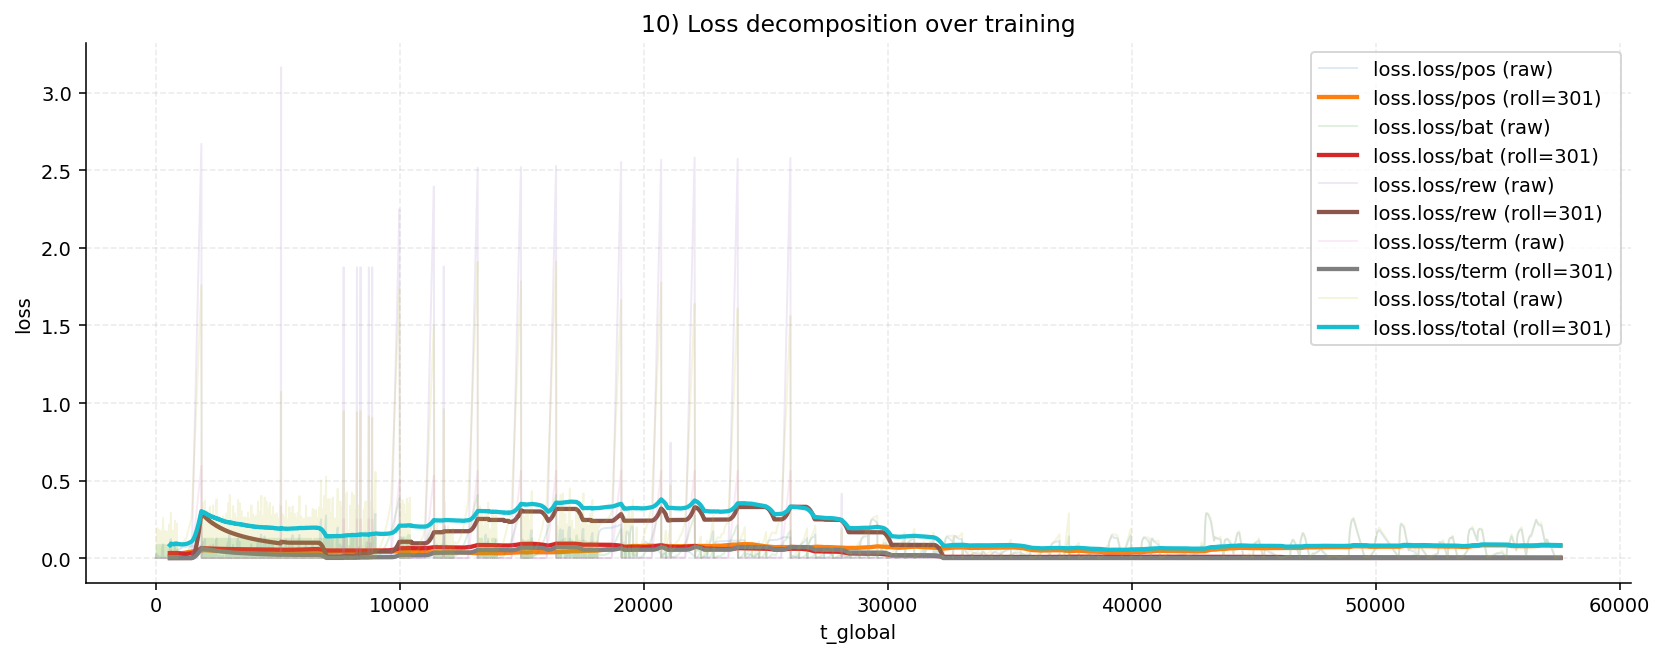

In [27]:
def plot_loss_decomposition(df: pd.DataFrame, mode="train", roll=301):
    d = prepare_df_for_plots(df, mode=mode, only_updates=False)
    xcol = _pick_xcol(d)

    cols = [
        "loss.loss/pos",
        "loss.loss/bat",
        "loss.loss/rew",
        "loss.loss/term",
        "loss.loss/total",
    ]
    available = [c for c in cols if c in d.columns]
    if len(available) == 0:
        raise KeyError(f"No loss columns found. Expected one of: {cols}")

    for c in available:
        _maybe_num(d, c)

    dd = d[[xcol] + available].dropna()
    if len(dd) == 0:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(12, 4.8))
    for c in available:
        plt.plot(dd[xcol], dd[c], alpha=0.15, linewidth=1, label=f"{c} (raw)")
        plt.plot(dd[xcol], _rolling(dd[c], roll), linewidth=2.2, label=f"{c} (roll={roll})")

    plt.title("10) Loss decomposition over training")
    plt.xlabel(xcol)
    plt.ylabel("loss")
    _style_ax(plt.gca())
    plt.legend(loc="upper right", frameon=True, ncol=1)
    plt.tight_layout()
    plt.show()

plot_loss_decomposition(df, mode="train", roll=301)


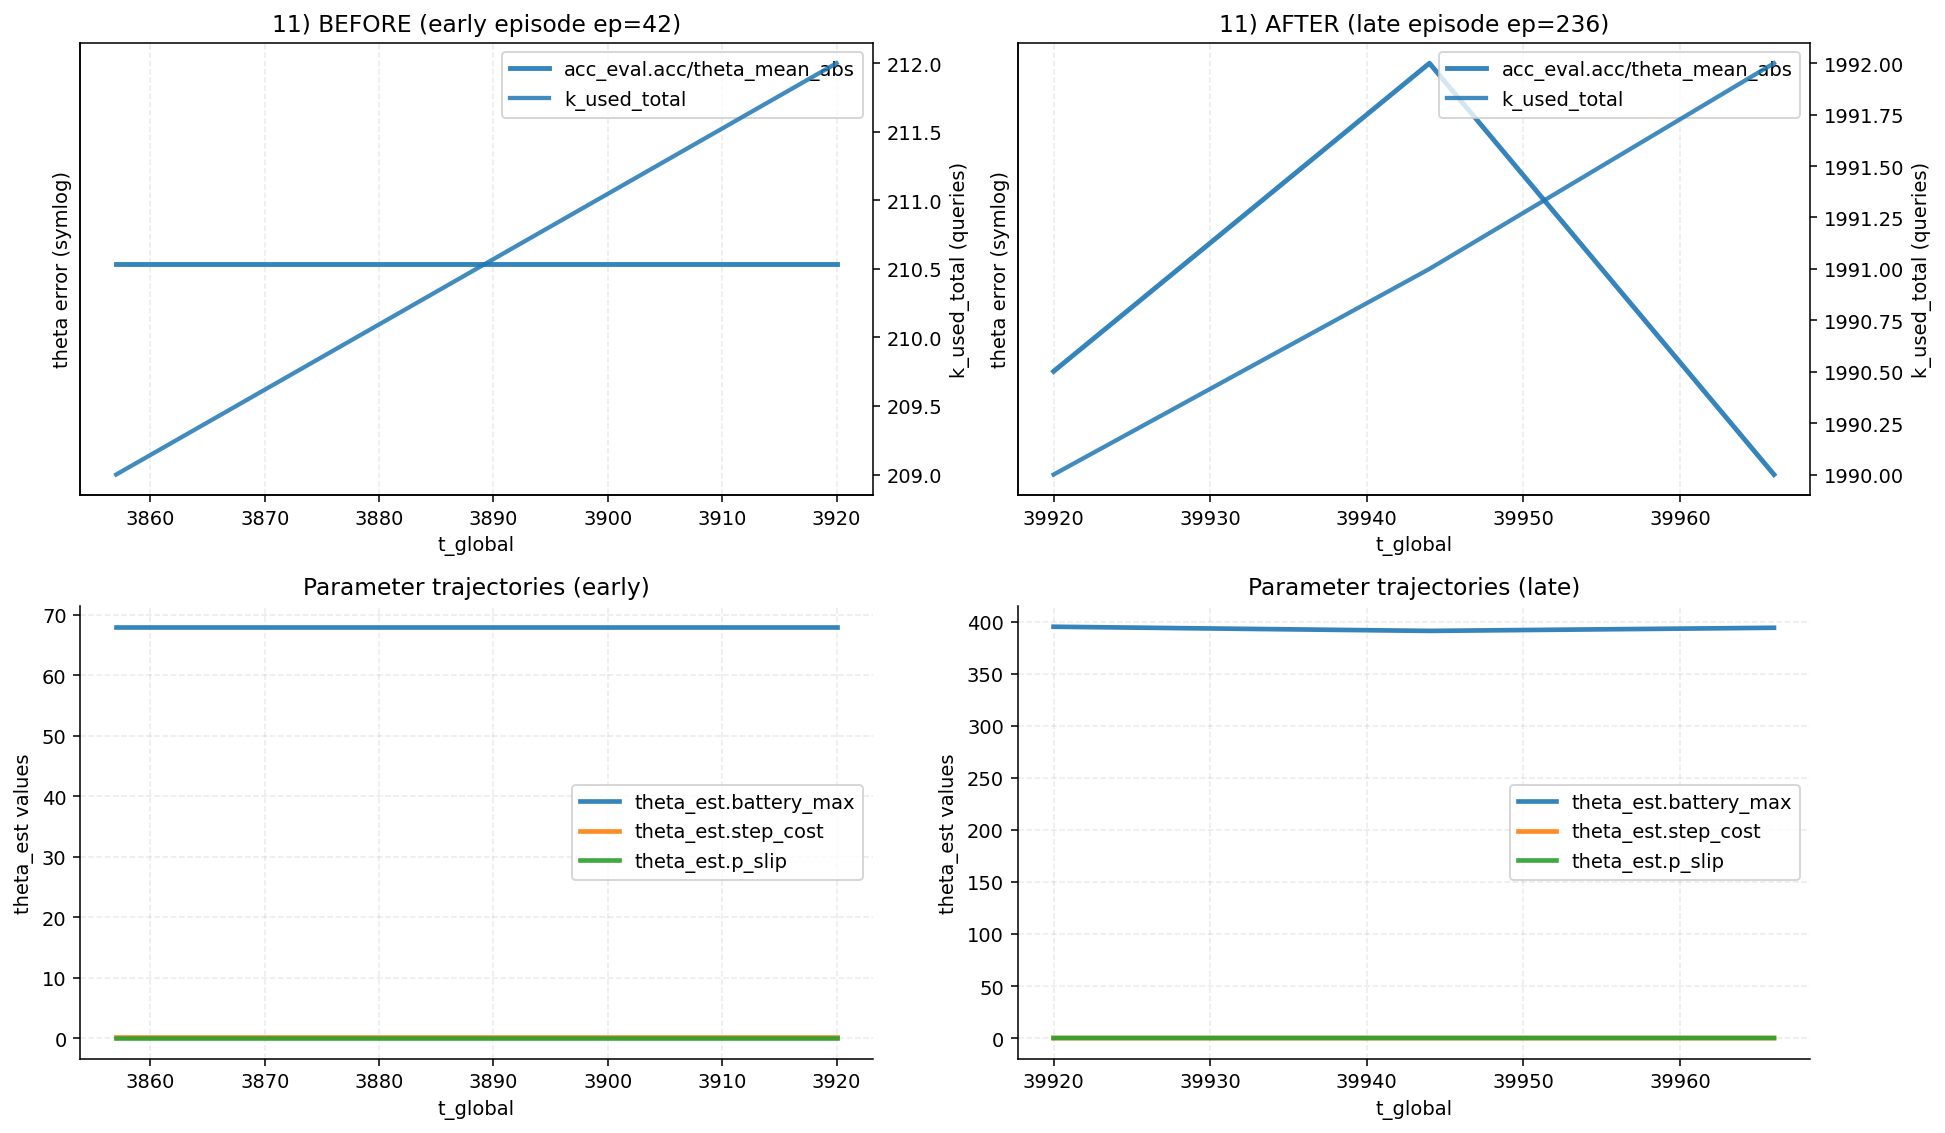

Selected episodes: early=42, late=236
Using error column: acc_eval.acc/theta_mean_abs


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.dpi"] = 140

def _pick_xcol(df: pd.DataFrame) -> str:
    for c in ["t_global", "_x"]:
        if c in df.columns:
            return c
    raise KeyError("Need time column: expected 't_global' or '_x' in dataframe.")

def _maybe_num(df: pd.DataFrame, col: str) -> None:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

def _style_ax(ax):
    ax.grid(True, which="both", ls="--", alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

def _select_episode_pair(df: pd.DataFrame, mode="train", early_q=0.15, late_q=0.85):
    """
    Picks one early and one late episode based on episode index quantiles.
    Falls back if columns missing.
    """
    d = df.copy()
    if "log_mode" in d.columns and mode is not None:
        d = d[d["log_mode"] == mode].copy()

    if "ep" not in d.columns:
        raise KeyError("Need 'ep' column to select early/late episodes.")

    d["ep"] = pd.to_numeric(d["ep"], errors="coerce")
    d = d.dropna(subset=["ep"])
    if len(d) == 0:
        raise ValueError("No rows after filtering for episode selection.")

    eps = np.sort(d["ep"].unique())
    e_early = eps[int(np.clip(round(early_q * (len(eps) - 1)), 0, len(eps) - 1))]
    e_late  = eps[int(np.clip(round(late_q  * (len(eps) - 1)), 0, len(eps) - 1))]
    return int(e_early), int(e_late)

def _episode_df(df: pd.DataFrame, ep: int, mode="train"):
    d = df.copy()
    if "log_mode" in d.columns and mode is not None:
        d = d[d["log_mode"] == mode].copy()
    d["ep"] = pd.to_numeric(d["ep"], errors="coerce")
    d = d[d["ep"] == ep].copy()

    xcol = _pick_xcol(d)
    _maybe_num(d, xcol)
    d = d.dropna(subset=[xcol]).sort_values(xcol)

    if "event" in d.columns:
        d_upd = d[d["event"].astype(str).eq("oracle_update")].copy()
        if len(d_upd) >= 3:
            d = d_upd

    return d

def before_after_snapshot(df: pd.DataFrame,
                          mode="train",
                          early_ep=None,
                          late_ep=None,
                          early_q=0.15,
                          late_q=0.85,
                          show_true=False):
    """
    Two-column figure (early vs late episode).
    Shows:
      - k_used_total (right axis) + theta error (left axis) in the top row
      - theta_est parameters in the bottom row

    Notes:
      - Uses oracle_update points when available to highlight calibration moments.
      - show_true overlays theta_true_eval_only.* if you want (eval-only).
    """
    if early_ep is None or late_ep is None:
        early_ep, late_ep = _select_episode_pair(df, mode=mode, early_q=early_q, late_q=late_q)

    dE = _episode_df(df, early_ep, mode=mode)
    dL = _episode_df(df, late_ep, mode=mode)

    xcolE = _pick_xcol(dE)
    xcolL = _pick_xcol(dL)

    err_candidates = ["acc_eval.acc/theta_mean_abs", "acc_no_gt.acc/theta_mean_abs", "acc.acc/theta_mean_abs"]
    err_col = next((c for c in err_candidates if c in df.columns), None)

    op_cols = ["acc_no_gt.acc/pos_mse", "acc_no_gt.acc/bat_mse", "acc_no_gt.acc/rew_mae"]
    op_cols = [c for c in op_cols if c in df.columns]

    # theta params
    theta_cols = ["theta_est.battery_max", "theta_est.step_cost", "theta_est.p_slip"]
    theta_cols = [c for c in theta_cols if c in df.columns]
    if len(theta_cols) == 0:
        raise KeyError("No theta_est.* columns found in df.")

    # ensure numeric
    for c in [err_col, "k_used_total"] + op_cols + theta_cols:
        if c is not None and c in dE.columns:
            _maybe_num(dE, c)
        if c is not None and c in dL.columns:
            _maybe_num(dL, c)

    fig = plt.figure(figsize=(14, 8.2))

    def _top_panel(ax, d, xcol, title):
        ax2 = ax.twinx()

        if "k_used_total" in d.columns:
            ax2.plot(d[xcol], d["k_used_total"], linewidth=2.2, alpha=0.85, label="k_used_total")
            ax2.set_ylabel("k_used_total (queries)")

        if err_col is not None and err_col in d.columns:
            ax.plot(d[xcol], d[err_col], linewidth=2.5, alpha=0.9, label=err_col)
            ax.set_yscale("symlog", linthresh=0.1)
            ax.set_ylabel("theta error (symlog)")
        else:
            if len(op_cols) > 0:
                for c in op_cols:
                    ax.plot(d[xcol], d[c], linewidth=2.2, alpha=0.85, label=c)
                ax.set_ylabel("no-GT errors")

        ax.set_title(title)
        ax.set_xlabel(xcol)
        _style_ax(ax)

        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax.legend(h1 + h2, l1 + l2, loc="upper right", frameon=True)

    ax_tl = plt.subplot2grid((2, 2), (0, 0))
    ax_tr = plt.subplot2grid((2, 2), (0, 1))
    _top_panel(ax_tl, dE, xcolE, f"11) BEFORE (early episode ep={early_ep})")
    _top_panel(ax_tr, dL, xcolL, f"11) AFTER (late episode ep={late_ep})")

    def _bottom_panel(ax, d, xcol, title):
        for c in theta_cols:
            ax.plot(d[xcol], d[c], linewidth=2.4, alpha=0.9, label=c)

        if show_true:
            for c in theta_cols:
                p = c.split("theta_est.", 1)[-1]
                true_c = f"theta_true_eval_only.{p}"
                if true_c in d.columns and d[true_c].notna().any():
                    _maybe_num(d, true_c)
                    ax.plot(d[xcol], d[true_c], linestyle="--", linewidth=2.0, alpha=0.9,
                            label=f"{true_c} (eval-only)")

        ax.set_title(title)
        ax.set_xlabel(xcol)
        ax.set_ylabel("theta_est values")
        _style_ax(ax)
        ax.legend(loc="best", frameon=True)

    ax_bl = plt.subplot2grid((2, 2), (1, 0))
    ax_br = plt.subplot2grid((2, 2), (1, 1))
    _bottom_panel(ax_bl, dE, xcolE, "Parameter trajectories (early)")
    _bottom_panel(ax_br, dL, xcolL, "Parameter trajectories (late)")

    plt.tight_layout()
    plt.show()

    print(f"Selected episodes: early={early_ep}, late={late_ep}")
    if err_col is not None:
        print(f"Using error column: {err_col}")
    else:
        print("No theta_mean_abs column found; using no-GT metrics in the top panel.")


before_after_snapshot(df, mode="train", early_ep=None, late_ep=None, show_true=False)
